<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Project/Generate_Faces/Face_Generation%5BDCGAN%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Generation 

## AIM:

To generate fake faces from the "Large-scale CelebFaces Attributes (CelebA) Dataset" from the Chinese University of HongKong. 

I will use GAN (DCGAN) for generating faces. 

In [4]:
!unzip '/content/drive/My Drive/processed-celeba-small.zip'

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052344.jpg  
  inflating: 

In [5]:
ls

drive/  __MACOSX/  processed_celeba_small/  sample_data/


## Import Files and Dependencies

In [6]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# other scripts
import unittest as test 
import helper

# define directory
data_dir = '/content/processed_celeba_small/celeba'

## Load and Preprocess Data

To load data I will use pytorch's [image folder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) method.

```
CLASS torchvision.datasets.ImageFolder(root, transform=None, 
  target_transform=None, loader=<function default_loader>, is_valid_file=None)
```

In [7]:
def get_dataloader(batch_size, image_size, data_dir = data_dir):
  # generate implement functions for dataloader
  transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
  image_dataset = datasets.ImageFolder(data_dir,transform)
  return torch.utils.data.DataLoader(image_dataset,batch_size = batch_size, shuffle=True)
  

## Create DataLoader

Dataloader is used to load data to model and we can easily modify model and hyperparamters if required.

In [8]:
# define model and hyper parameters
batch_size = 128
img_size = 32

train_loader = get_dataloader(batch_size, img_size)

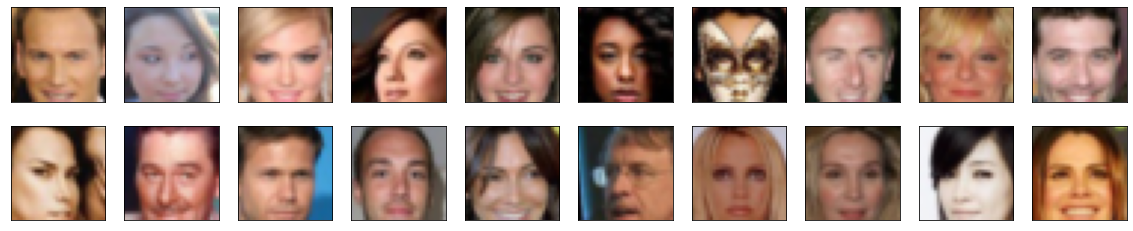

In [9]:
# display function
def imshow(img):
  image = img.numpy()
  plt.imshow(np.transpose(image, (1,2,0)))

# obtain one image batch
dataiter = iter(train_loader)
images,_ = dataiter.next() 

# plot image in batch
fig = plt.figure(figsize = (20,4))
plot_size = 20
for idx in np.arange(plot_size):
  ax = fig.add_subplot(2,plot_size/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])

Rescale data in range of (-1,1)

In [10]:
# preprocess data by scalling
def scale(x, feature_range = (-1,1)):
  min, max = feature_range
  return x * (max-min) + min

In [11]:
img = images[0]
scaled_img = scale(img)

print('Min: ',scaled_img.min())
print('Max: ',scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.8745)


## Define Model 

A GAN is combined network of discriminator and generator. So, for complete GAN I will define the full architecture of discriminator and generator.

### Discriminaor:

Discriminator is one kind of classifier with convolution layers. Accuracy of GAN is depend on the disriminator. More powerful discriminator will betterly identify the model and result as more accurate GAN.

It will takes 32x32x3 dimension image as tensor and result it to real of fake image. 

In [12]:
# define convolution layers for Discriminator (apply batch_norm for 2nd, 3rd and later layers)
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm = True):
  layers = []
  conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  layers.append(conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [27]:
# define discriminator architecture
class Discriminator(nn.Module):
  def __init__(self,conv_dim):
    super(Discriminator,self).__init__()
    self.conv_dim = conv_dim
    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
    self.conv2 = conv(conv_dim, conv_dim *2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4,4)
    self.conv4 = conv(conv_dim*4, conv_dim*8,4)

    self.fc = nn.Linear(conv_dim*8*2*2,1)

  def forward(self,x):
    out = F.leaky_relu(self.conv1(x),0.2)
    out = F.leaky_relu(self.conv2(out),0.2)
    out = F.leaky_relu(self.conv3(out),0.2)
    out = F.leaky_relu(self.conv4(out),0.2)
    out = out.view(-1, self.conv_dim * 8*2*2)          # flatten image to tensor
    out = self.fc(out)
    return out

## Generator

Generator is network, which takes the random noise data and try to convert it in image. Ofcause, with out any idea generator try to make randomization. But, after some iterations it will takes the loss difference from discriminator and adjust result in such way that discriminator fools by fake image data and such images will visualize as real images. 

So, the state is called equilizer point.

In [28]:
# generate deconv layer for the generator
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False))
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [66]:
# define generator architecture (reverse process of discriminator)
class Generator(nn.Module):
  def __init__(self, z_size, conv_dim):
    super(Generator, self).__init__()
    self.conv_dim = conv_dim
    self.fc = nn.Linear(z_size, conv_dim*8*2*2)
    
    self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
    self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
    self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
    self.t_conv4 = deconv(conv_dim , 3, 4, batch_norm=False) 

  def forward(self,x):
    out = self.fc (x)
    out = out.view(-1, self.conv_dim*8,2,2)
    
    out = F.relu(self.t_conv1(out))
    out = F.relu(self.t_conv2(out))
    out = F.relu(self.t_conv3(out))

    out = self.t_conv4(out)
    out = F.tanh(out)
    return out

#### Weight Initialization

Here, the weight is initialized to convolution and linear layers only. I will add the wight which will be nomalized around 0 and the standard deviation will be 0.02. 

In [67]:
from torch.nn import init

def weight_init_normal(m):
  classname = m.__class__.__name__
  isConvolution = classname.find('Conv') != -1
  isLinear = classname.find('Linear') != -1
  if (hasattr(m, 'weight') and isConvolution or isLinear):
    init.normal_(m.weight.data,0.0,0.02)

### Complete Network

Let's combine the discriminator and generator from the defined class and get the full network architecture.

In [68]:
def GAN_Network(d_conv_dim, g_conv_dim, z_size):
  D = Discriminator(d_conv_dim)
  G = Generator(z_size = z_size, conv_dim = g_conv_dim)

  # initialize model weights
  D.apply(weight_init_normal)
  G.apply(weight_init_normal)

  print(D)
  print('======')
  print(G)

  return D,G

In [69]:
# print Network with hyperparameters

d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = GAN_Network(d_conv_dim,g_conv_dim,z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

### Losses and Optimizers

Discriminator and Generator has their own seperate losses. Discriminator loss will further be divided in real and fake image losses. 

So, d_loss = d_real_loss + d_fake_loss

Generator loss is similar to discriminator loss, the only change is flipped labels.


In [112]:
# real loss for discriminator output = 1
def real_loss(D_out):
  batch_size = D_out.size(0)
  labels = (torch.ones(batch_size)) * 0.9
  if train_on_gpu:
    labels = labels.cuda()
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss

# fake loss for discriminator output = 0
def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  if train_on_gpu:
    labels = labels.cuda()
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(),labels)
  return loss

Optimizer is used to optimize the model and here, I will use Adam optimizer.


In [114]:
lr = 0.0002
beta1 = 0.5   # use default value
beta2 = 0.999 # use default value

# create optimizer for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1,beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1,beta2])

## Training 

The training between the generator and discriminator works alternatively. So, first generator generates image and pass it to discriminator. 

Discriminator either pass it or reject it based on its previous training. If image pass then the loss calculation known as real_loss, in case of rejection of image the status of image taken as 0, and considered as fake_loss. 

It is understandabe that, after seeral iteration, model will reach to great accuracy. Well, it also depends on hyperparameters such as learning rate, weight initialization, iteration, optimizer, no. of layers, layer depth etc...




In [115]:
# generate training loop
def train(D, G, n_epochs, print_every = 100):
  # move models to GPU
  if train_on_gpu:
    D.cuda()
    G.cuda()

  # tracking losses and sample
  samples = []
  losses = []

  # initialize noise data and transfer in sample_size 
  sample_size = 16
  fixed_z = np.random.uniform(-1,1,size=(sample_size,z_size))
  fixed_z = torch.from_numpy(fixed_z).float()                   # turn to tensor
  if train_on_gpu:
    fixed_z = fixed_z.cuda()
    
    # generate epoch training loop
    for epoch in range(n_epochs):
      for batch_i, (real_images,_) in enumerate(train_loader):
        batch_size = (real_images.size(0)) 
        real_images = scale(real_images)

        # Train Discriminator
        d_optimizer.zero_grad()
        if train_on_gpu:
          real_images = real_images.cuda()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)

        # generate random noise sample image
        z = np.random.uniform(-1,1, size = (batch_size,z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
          z = z.cuda()
        
        # repeat the process for fake_images
        fake_images = G(z)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # for generator with adversarial loss
        g_optimizer.zero_grad()

        z = np.random.uniform(-1,1,size=(batch_size,z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
          z = z.cuda()

        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
          losses.append((d_loss.item(), g_loss.item()))
          print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

    # Generate samples after each iteration.  
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)      
    G.train()
  with open('train_samples.pkl','wb') as f:
    pkl.dump(samples,f)

  return losses


In [116]:
# get gpu before training
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('No gpu, going to run on local machine - reduce iteration (may affect the result accuracy')
else:
  print('Training on GPU!')
  print(torch.cuda.get_device_name(0))

Training on GPU!
Tesla T4


In [117]:
# call the training function
n_epochs = 20
losses = train(D,G,n_epochs = n_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   20] | d_loss: 1.0163 | g_loss: 5.6549
Epoch [    1/   20] | d_loss: 0.4837 | g_loss: 6.6797
Epoch [    1/   20] | d_loss: 0.4532 | g_loss: 5.8859
Epoch [    1/   20] | d_loss: 0.4449 | g_loss: 5.0597
Epoch [    1/   20] | d_loss: 0.4316 | g_loss: 6.4192
Epoch [    2/   20] | d_loss: 0.4221 | g_loss: 6.3141
Epoch [    2/   20] | d_loss: 0.4223 | g_loss: 4.1387
Epoch [    2/   20] | d_loss: 0.4922 | g_loss: 5.7876
Epoch [    2/   20] | d_loss: 0.4789 | g_loss: 4.8989
Epoch [    2/   20] | d_loss: 0.5349 | g_loss: 6.2778
Epoch [    3/   20] | d_loss: 0.4674 | g_loss: 5.1321
Epoch [    3/   20] | d_loss: 0.4657 | g_loss: 6.1386
Epoch [    3/   20] | d_loss: 0.4187 | g_loss: 6.2377
Epoch [    3/   20] | d_loss: 0.4761 | g_loss: 5.9589
Epoch [    3/   20] | d_loss: 0.4159 | g_loss: 5.8336
Epoch [    4/   20] | d_loss: 0.4061 | g_loss: 5.2852
Epoch [    4/   20] | d_loss: 0.4414 | g_loss: 5.3067
Epoch [    4/   20] | d_loss: 0.3945 | g_loss: 4.1884
Epoch [    4/   20] | d_loss

### Try and Observation

- Try 1: Epoch [   20/   20] | d_loss: 1.1393 | g_loss: 0.6597  (0.001)_Weak Model
- Try 2: Epoch [   20/   20] | d_loss: 0.0328 | g_loss: 5.8045 (0.0001) _ Underfit
- Try 3 : Epoch [   20/   20] | d_loss: 0.1697 | g_loss: 6.1041 (0.005)
- Try 4 : (0.0007) near to same output as above - underfit model (loss does not drops)
- Try 5 : (0.0002 + label smoothing) -> 

# WAIT

### Training Loss 

Here, I will compare our loss scenario for each iteration over time 


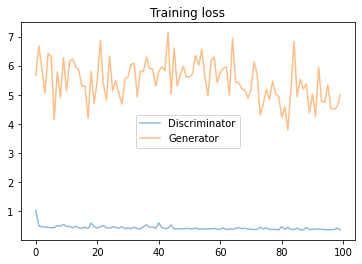

In [118]:
fig,ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator',alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title('Training loss')
plt.legend()

## Sample Review



In [119]:
# visualize samples (taken from previous notebook code)
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [120]:
# load sample generator file 
with open('train_samples.pkl','rb') as f:
  samples = pkl.load(f)

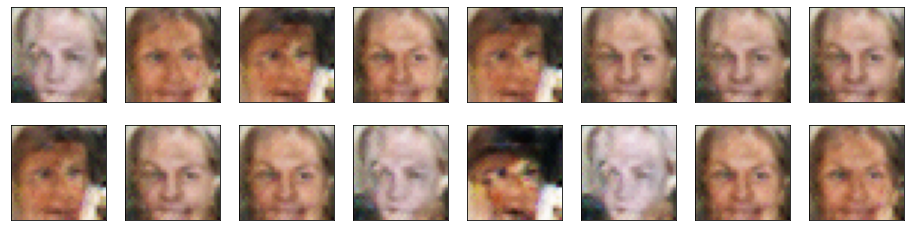

In [121]:
sample1 = view_samples(-1,samples)

In [122]:
# keep learning, Enjoy Empowering